In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sqlite3 import Error
from sklearn.ensemble import RandomForestClassifier
import sqlite3
import pickle
import nltk
nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
dataset = pd.read_csv("bbc-text.csv")
print(dataset.head())

        category                                               text
0           tech  tv future in the hands of viewers with home th...
1       business  worldcom boss  left books alone  former worldc...
2          sport  tigers wary of farrell  gamble  leicester say ...
3          sport  yeading face newcastle in fa cup premiership s...
4  entertainment  ocean s twelve raids box office ocean s twelve...


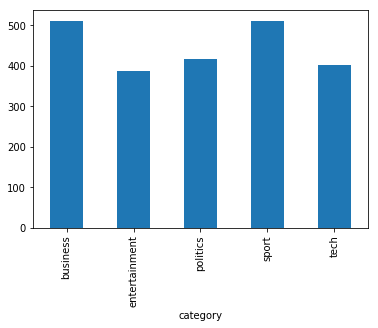

In [3]:
dataset.groupby('category').text.count().plot.bar(ylim=0)
plt.show()

In [4]:
nltk.download('stopwords')
stemmer = PorterStemmer()
words = stopwords.words("english")
dataset['cleaned'] = dataset['text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
dataset.head()

,category,text,cleaned
0,tech,tv future in the hands of viewers with home th...,tv futur hand viewer home theatr system plasma...
1,business,worldcom boss left books alone former worldc...,worldcom boss left book alon former worldcom b...
2,sport,tigers wary of farrell gamble leicester say ...,tiger wari farrel gambl leicest say rush make ...
3,sport,yeading face newcastle in fa cup premiership s...,yead face newcastl fa cup premiership side new...
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean twelv raid box offic ocean twelv crime c...


In [6]:
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features = vectorizer.fit_transform(dataset['cleaned']).toarray()
final_features.shape

(2225, 29637)

In [7]:
from sklearn.linear_model import LogisticRegression
X = dataset['cleaned']
Y = dataset['category']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=1200)),
                     ('clf', LogisticRegression(random_state=0))])

model = pipeline.fit(X_train, y_train)
with open('LogisticRegression.pickle', 'wb') as f:
    pickle.dump(model, f)

ytest = np.array(y_test)

# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


               precision    recall  f1-score   support

     business       0.94      0.99      0.97       133
entertainment       1.00      0.98      0.99        91
     politics       0.97      0.94      0.96       103
        sport       0.99      0.99      0.99       131
         tech       0.98      0.96      0.97        99

     accuracy                           0.97       557
    macro avg       0.98      0.97      0.97       557
 weighted avg       0.98      0.97      0.97       557

[[132   0   1   0   0]
 [  0  89   2   0   0]
 [  3   0  97   1   2]
 [  1   0   0 130   0]
 [  4   0   0   0  95]]


In [13]:
from sklearn.metrics import roc_curve
#from sklearn.linear_model import LogisticRegression
#import sklearn.linear_model as sk
#logreg = sk.LogisticRegressionCV()
# Compute predicted probabilities: y_pred_prob
y_pred_prob = LogisticRegression.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_train)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

TypeError: ignored